# Imports

In [4]:
import ete3
from urllib.request import urlopen
import xmltodict
import pandas as pd
import os
import seaborn as sns
from Bio import SeqIO
import collections
import matplotlib.pyplot as plt
import numpy as np
# import dendropy
import time
import subprocess
%matplotlib inline

# Define helper functions for plotting and decorating the trees 

In [5]:
datapath = "../Data"
tmppath = "."

In [27]:
def decorate(tree, bayes=False, prot=False):
    for leaf in tree:
        try:
            s = leaf.name.split('_')[1]
        except:
            print(leaf.name)
        if bayes:
            pID = leaf.name
        else:
            try:
                pID = leaf.name.split('|')[2]
            except:
                pID = leaf.name
        x= uniprot_meta(pID)
        taxa = x['uniprot']['entry']['organism']['lineage']['taxon']
        if s in metadata:
            n = metadata[s]
        else:
            n = taxa[0][0] + '|' + taxa[-1]
        k = n.split('|')[0]
        leaf.kingdom= k 
        leaf.genus = taxa[1]
        
        leaf.protid = pID
        leaf.specID = s
        if '#text' not in x['uniprot']['entry']['organism']['name']:
            try:
                leaf.specie  = x['uniprot']['entry']['organism']['name'][0]['#text']
            except:
                print(x['uniprot']['entry']['organism']['name'])
        else:
            leaf.specie  = x['uniprot']['entry']['organism']['name']['#text']
        if 'recommendedName' in x['uniprot']['entry']['protein']:
            leaf.fullname = x['uniprot']['entry']['protein']['recommendedName']['fullName']['#text']
            leaf.shortname = x['uniprot']['entry']['protein']['recommendedName']['shortName']['#text']
        else:
            if len(x['uniprot']['entry']['protein']['submittedName']) != 1 and 'ecNumber' not in x['uniprot']['entry']['protein']['submittedName']:
                best= 0
                best_i = 0
                for i in range(len(x['uniprot']['entry']['protein']['submittedName'])):
                    e = int(x['uniprot']['entry']['protein']['submittedName'][i]['fullName']['@evidence'])
                    if e > best:
                        best = e
                        best_i = i
                leaf.fullname = x['uniprot']['entry']['protein']['submittedName'][best_i]['fullName']['#text']
                leaf.shortname = None
            else:
                leaf.fullname = x['uniprot']['entry']['protein']['submittedName']['fullName']['#text']
                leaf.shortname = None
        if 'Arthropoda' in taxa:
            k = 'Ar'
            leaf.kingdom=k
        nstyle = ete3.NodeStyle()
        if k == 'E':
            nstyle["fgcolor"] = "#55a868"
            nstyle["size"] = 15
        elif k == 'Ar':
            features = ''
            if 'feature' in x['uniprot']['entry']:
                feature = x['uniprot']['entry']['feature']            
                if type(feature) != collections.OrderedDict:
                    for i in feature:
                        if i['@type'] == 'domain':
                            features += i['@description'].lower()
                else:
                    if feature['@type'] == 'domain':
                        features = feature['@description'].lower()
            if 'osk' in leaf.fullname.lower():
                k = 'O'
            elif 'osk' in features:
                k = 'O'
            elif Test_Oskar(pID):
                k = 'O'
            if k == 'O':
                nstyle["fgcolor"] = "#8172b2"
                nstyle["size"] = 16
            else:
                nstyle["fgcolor"] = "#c44e52"
                nstyle["size"] = 15
            leaf.kingdom=k
        elif k == 'B':
            nstyle["fgcolor"] = "#4c72b0"
            nstyle["size"] = 15
        else:
            k = 'U'
            nstyle["fgcolor"] = "#ccb974"
            nstyle["size"] = 15
        leaf.set_style(nstyle)
        if leaf.shortname:
            n = leaf.shortname
        else:
            n = leaf.fullname
            if prot:
                leaf.name  =' '.join(leaf.specie.split(' ')[:2]) + ' - ' + n 
            else:
                if leaf.kingdom in ['B','A','U']:
                    leaf.name  =' '.join(leaf.specie.split(' ')[:4])
                else:
                    leaf.name  =' '.join(leaf.specie.split(' ')[:2])
    return tree
            
def uniprot_meta(accID):
    if not os.path.isdir(os.path.join(tmppath, 'uniprots')):
        os.mkdir(os.path.join(tmppath, 'uniprots'))
    uniprot_path = os.path.join(tmppath, 'uniprots', '{}.xml'.format(accID))
    if not os.path.isfile(uniprot_path):
        print("Downloading ", accID)
        url = "http://www.uniprot.org/uniprot/{}.xml".format(accID)
        with urlopen(url) as response:
            xml = response.read()
        handle = urlopen(url)
        xml = handle.read().decode()
        f = open(uniprot_path,'w')
        f.write(xml)
        f.close()
    else:
        xml = open(uniprot_path).read()
    xml = xmltodict.parse(xml)
    return xml

def Parse_HMMER_output(path):
    f = open(path)
    lines = f.readlines()
    f.close()
    collumns = ['target name', 'Prot_ID', 'Specie_ID', 'accession', 'query name', 'accession', 'Pre E-value', 'Pre score', 'Pre bias', 'E-value', 'score', 'bias', 'exp', 'reg', 'clu', 'ov', 'env', 'dom', 'rep', 'inc', 'description of target']
    res = []
    for line in lines:
        if line[0] != '#':
            s = [i for i in line.split(' ') if i]
            s = [s[0]] + [s[0].split('|')[2]] + [s[0].split('|')[2].split('_')[1]] + s[1:18] + [' '.join(s[18:])]
            res.append(s)
    df = pd.DataFrame(res, columns=collumns)
    return df

def Test_Oskar(accID):
    print("Testing if oskar")
    exist = False
    if accID not in uniprot_dl:
        if not os.path.isdir(os.path.join(tmppath, 'tmp')):
            os.mkdir(os.path.join(tmppath, 'tmp'))
        if not os.path.isfile(os.path.join(tmppath, 'tmp', '{}.fasta'.format(accID))):
            url = "http://www.uniprot.org/uniprot/%s.fasta" % (accID)
            with urlopen(url) as response:
                fasta = response.read()
            f = open(os.path.join(tmppath, 'tmp', '{}.fasta'.format(accID)), 'w')
            f.write(fasta.decode('utf-8'))
            f.close()
            handle = SeqIO.parse(os.path.join(tmppath, 'tmp', '{}.fasta'.format(accID)), 'fasta')
            try:
                for i in handle:
                    seq = i
                if i:
                    exist = True
                else:
                    exist = False
                uniprot_dl.append(accID)
            except:
                print(accID)
        else:
            exist = True
    else:
        exist = True
    if exist:
        out = subprocess.check_output(['hmmsearch',
                   '--cpu',
                   '7',
                   '-o',
                   'log_lotus',
                   '--tblout',
                   os.path.join(tmppath, 'tmp' ,'test_oskar_lotus.out'),
                   os.path.join(datapath, 'HMM','LOTUS.hmm'),
                   os.path.join(tmppath, 'tmp', '{}.fasta'.format(accID))]
                  )
        out = subprocess.check_output(['hmmsearch',
                           '--cpu',
                           '7',
                           '-o',
                           'log_osk',
                           '--tblout',
                           os.path.join(tmppath, 'tmp' ,'test_oskar_osk.out'),
                           os.path.join(datapath, 'HMM','OSK.hmm'),
                           os.path.join(tmppath, 'tmp', '{}.fasta'.format(accID))]
                          )
#         time.sleep(1)
        lotus = Parse_HMMER_output(os.path.join(tmppath, 'tmp' ,'test_oskar_lotus.out'))
        sgnh = Parse_HMMER_output(os.path.join(tmppath, 'tmp' ,'test_oskar_osk.out'))
        if len(sgnh) > 0 and len(lotus) == 0:
            f = open(os.path.join(tmppath, 'tmp' ,'toCheck'), 'a')
            f.write(accID + '\n')
        if len(lotus) > 0:
            if len(sgnh) > 0:
                return True
    return False

def Collapse_support(s, tree):
    a = tree.traverse()
    for i in a:
        if not i.name:
            if i.support < s:
                anc = i.get_ancestors()
                child = i.children
                if len(anc) > 0:
                    for c in child:
                        anc[-1].add_child(c)
                        i.detach()
                        
def remove_duplicate_specie(tree, ar=False):
    done = []
    for leaf in tree:
        if leaf.specID in done:
            if ar:
                if leaf.kingdom == 'Ar':
                    leaf.delete()
            else:
                leaf.delete()
        else:
            done.append(leaf.specID)
            
def DL_seq(accID, name):
    print("Doing ", accID)
    url = "http://www.uniprot.org/uniprot/%s.fasta" % (accID)
#     handle = urllib2.urlopen(url)
    with urlopen(url) as response:
        fasta = response.read()
    try:
        if fasta[0] == '>':
            f = open('./tmp/%s.fasta'%name, 'a')
            f.write(fasta)
            f.close()
    except:
        print("ERROR: ",accID)

# Define paths

In [40]:
taxonomy = os.path.join(datapath, "Taxonomy", "uniprot_ID_taxa.tsv")

LOTUS_prank_path = '../Prank_Alignment/RAxML_bipartitions.LOTUS_animala_PRANK_100'
OSK_prank_path = '../Prank_Alignment/RAxML_bipartitions.SGNH_hmmalign_prank_aligned.trimmed_0.3'

LOTUS_tcoffee_path = '../tcoffee_alignement/RAxML_bipartitions.LOTUS_animala_T_Coffee'
OSK_tcoffee_path = '../tcoffee_alignement/RAxML_bipartitions.SGNH_Tree_base'

LOTUS_sowhat = '../../../Phylogeny/SowhatAnalysis/lotus_mono/first_run/sowhat_scratch/RAxML_bestTree.ml.0.0'

# #RAXML TREES
# LOTUS_animala_path = os.path.join(datapath, 'Trees', 'LOTUS.raxml.bipartitions')
# SGNH_RaxML_noPut_path = os.path.join(datapath, 'Trees', 'OSK.raxml.bipartitions')

# #Mr BAYES TREES
# LOTUS_animala_Bayes_path = os.path.join(datapath, 'Trees', 'LOTUS.bayes.nexus.con.tre')
# SGNH_Bayes_noPut_path = os.path.join(datapath, 'Trees', 'OSK.bayes.nexus.con.tre')
                                    
# # SOWHAT Best Trees
# OSK_kingdom_sowhat = os.path.join(datapath, 'Trees', 'SOWHAT_kingdom_test.tre')
# OSK_eukmono_sowhat = os.path.join(datapath, 'Trees', 'SOWHAT_eukmono_test.tre')

## Reading the metadata and loading the trees in a format compatible with ETE3

In [9]:
metadata = {}
f = open(taxonomy)
lines = f.readlines()
for i in range(len(lines)):
    line = lines[i].strip()
    s = line.split('\t')
    spec = s[2].split(',')[-1]
    kingdom = s[2].split(',')[0]
    acc = s[0]
    metadata[acc] = kingdom[0] + '|' + spec
uniprot_dl = []

In [10]:
# data = dendropy.DataSet.get_from_path(LOTUS_animala_Bayes_path, "nexus")
# data.write_to_path(LOTUS_animala_Bayes_path+ ".xml", "nexml")
# LOTUS_animala_Bayes_path = LOTUS_animala_Bayes_path + '.xml'

# data = dendropy.DataSet.get_from_path(SGNH_Bayes_noPut_path, "nexus")
# data.write_to_path(SGNH_Bayes_noPut_path+ ".xml", "nexml")
# SGNH_Bayes_noPut_path = SGNH_Bayes_noPut_path+ ".xml"



# Tree Plotting 

# Defining Parameters for Supp Info Trees

In [11]:
ts = ete3.TreeStyle()
ts.show_branch_support = True
ts.show_scale = True
ts.show_leaf_name = True
ts.complete_branch_lines_when_necessary = True

# LOTUS Trees after PRANK alignement

## RaxML tree

### Creating and decorating the tree

In [12]:
LOTUS_animala = ete3.Tree(open(LOTUS_prank_path).read())
LOTUS_animala = decorate(LOTUS_animala)
for leaf in LOTUS_animala:
    if leaf.kingdom == 'B':
        LOTUS_animala.set_outgroup( leaf )
trav = LOTUS_animala.traverse()
for node in trav:
    node.img_style['hz_line_width'] = 2
    node.img_style['vt_line_width'] = 2
for leaf in LOTUS_animala:
    leaf.name= '  '+ leaf.protid + ' | ' + leaf.specie + ' | ' + leaf.fullname

Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar


### Plotting the tree

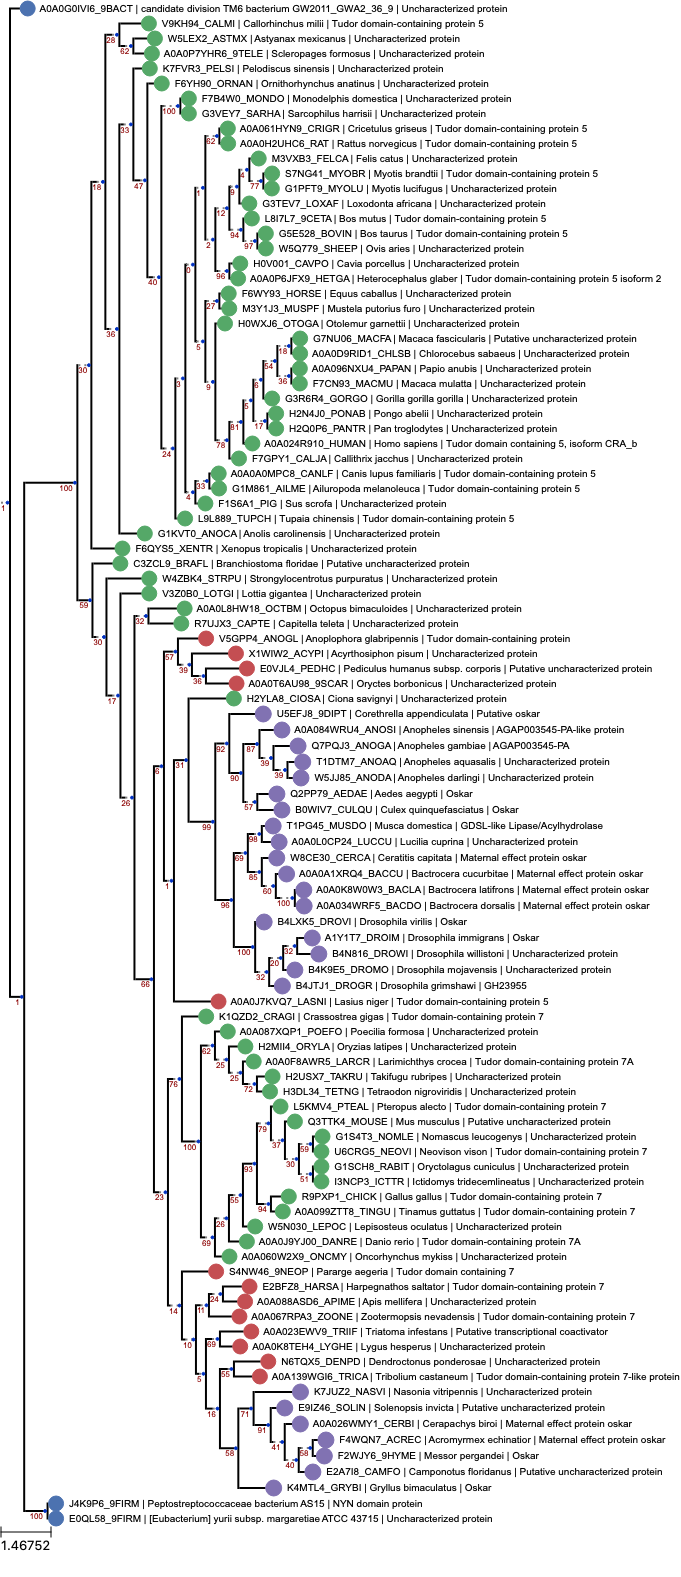

In [13]:
LOTUS_animala.render('%%inline', tree_style=ts)

In [21]:
LOTUS_animala.render('LOTUS_prank.pdf', tree_style=ts, units='mm', h=247, dpi=600)
LOTUS_animala.render('LOTUS_prank.png', tree_style=ts, units='mm', h=247, dpi=600)
LOTUS_animala.render('LOTUS_prank.svg', tree_style=ts, units='mm', h=247, dpi=600)

{'faces': [[1111.2897295661478,
   1344.8913751579519,
   2058.4484421945813,
   1381.8897623700002,
   59,
   '  A0A096NXU4_PAPAN | Papio anubis | Uncharacterized protein'],
  [841.8160799595476,
   1178.398632703735,
   1800.0743087515957,
   1215.3970199157832,
   49,
   '  H0WXJ6_OTOGA | Otolemur garnettii | Uncharacterized protein'],
  [890.2325907092409,
   1011.9058902495182,
   2281.371949882253,
   1048.9042774615664,
   43,
   '  A0A0P6JFX9_HETGA | Heterocephalus glaber | Tudor domain-containing protein 5 isoform 2'],
  [569.5922071334912,
   4414.843393448905,
   602.8907556243346,
   4448.141941939748,
   133,
   '23'],
  [748.7054088304392,
   1416.5179404012765,
   763.5047637152585,
   1449.8164888921199,
   48,
   '9'],
  [861.2681904763465,
   1122.9010518856628,
   1852.824967759238,
   1159.899439097711,
   47,
   '  M3Y1J3_MUSPF | Mustela putorius furo | Uncharacterized protein'],
  [946.1977390068985,
   5275.970016438073,
   979.4962874977417,
   5309.268564928916

# OSK Trees after PRANK alignment

## RaxML tree

### Creating and decorating the tree

In [24]:
c = 0 
for leaf in SGNH_RaxML_noPut:
    c+=1
print(c)

87


In [31]:
SGNH_RaxML_noPut = ete3.Tree(open(OSK_prank_path).read())
decorate(SGNH_RaxML_noPut, bayes=False)
for leaf in SGNH_RaxML_noPut:
    if 'milii' in leaf.name:
        SGNH_RaxML_noPut.set_outgroup( leaf )
remove_duplicate_specie(SGNH_RaxML_noPut, ar=True)
trav = SGNH_RaxML_noPut.traverse()
for node in trav:
    node.img_style['hz_line_width'] = 2
    node.img_style['vt_line_width'] = 2
for leaf in SGNH_RaxML_noPut:
    if "candidate division" in leaf.specie:
        leaf.name = 'WWE3 bacterium'
    if leaf.kingdom == 'A':
        print(leaf)
        SGNH_RaxML_noPut.set_outgroup( leaf )
    leaf.name= '  '+ leaf.protid + '| ' + leaf.genus + ' | ' + leaf.specie + ' | ' + leaf.fullname

Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar

--Methanosarcina barkeri str. Wiesmoor

--Methanosarcina barkeri CM1


### Plotting the tree

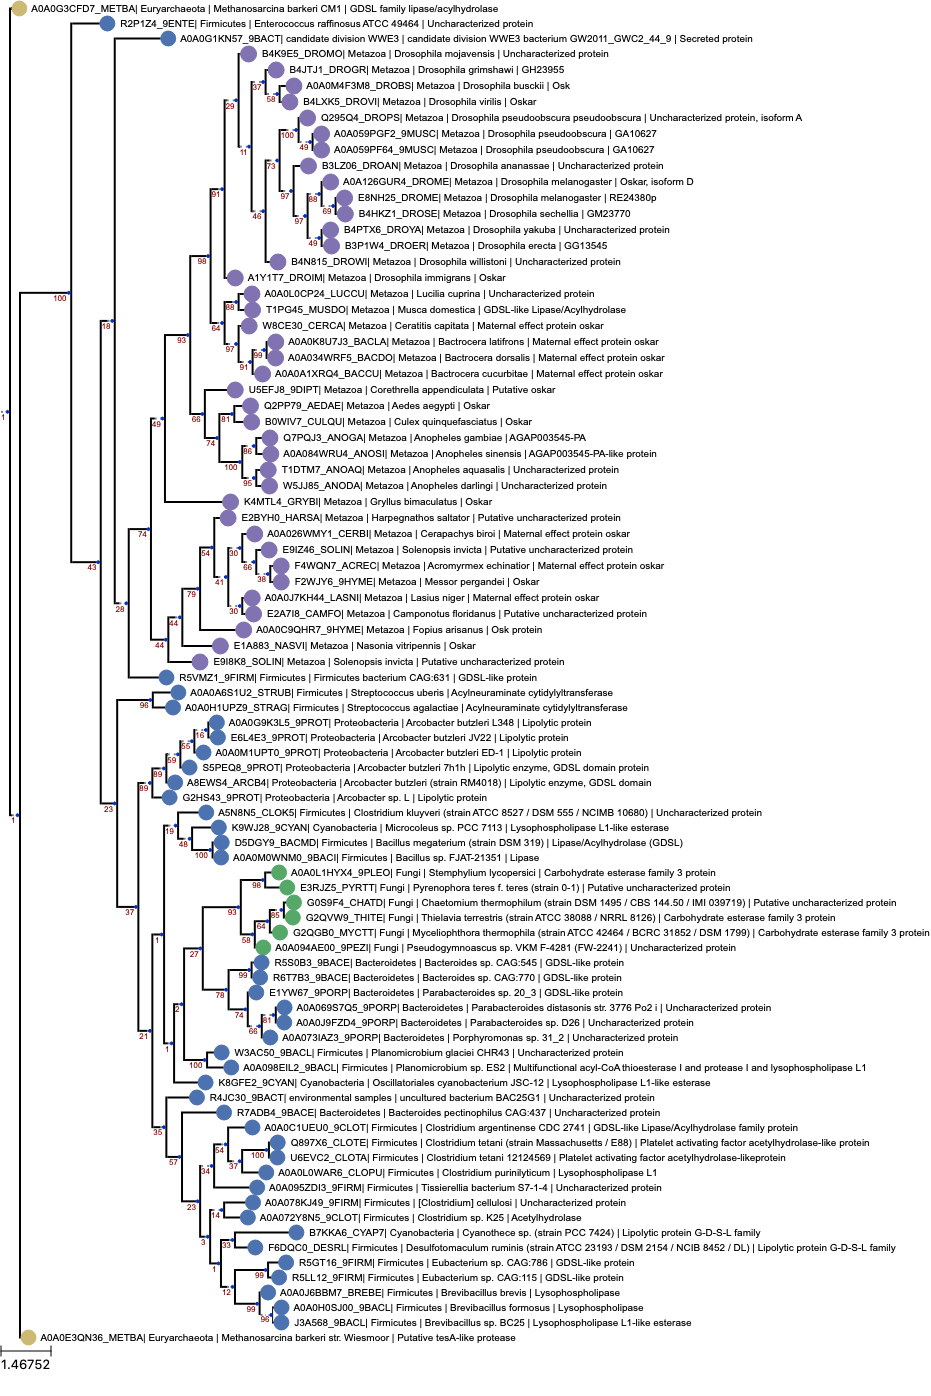

In [32]:
SGNH_RaxML_noPut.render('%%inline', tree_style=ts)

In [24]:
SGNH_RaxML_noPut.render('OSK_prank.pdf', tree_style=ts, units='mm', h=247,  dpi=600)
SGNH_RaxML_noPut.render('OSK_prank.png', tree_style=ts, units='mm', h=247,  dpi=600)
SGNH_RaxML_noPut.render('OSK_prank.svg', tree_style=ts, units='mm', h=247,  dpi=600)

{'faces': [[1144.2870556748705,
   4315.38083624538,
   2406.509828116618,
   4357.176292286497,
   136,
   '  A0A073IAZ3_9PORP | Porphyromonas sp. 31_2 | Uncharacterized protein'],
  [1365.049610704315,
   606.0341125962035,
   2430.8337397528107,
   647.829568637321,
   28,
   '  A0A059PF64_9MUSC | Drosophila pseudoobscura | GA10627'],
  [846.1587425226094,
   4566.153572492085,
   2133.458788589028,
   4607.949028533202,
   142,
   '  R4JC30_9BACT | uncultured bacterium BAC25G1 | Uncharacterized protein'],
  [1257.8210487233791,
   5130.392229047171,
   2712.302918954267,
   5172.187685088288,
   161,
   '  B7KKA6_CYAP7 | Cyanothece sp. (strain PCC 7424) | Lipolytic protein G-D-S-L family'],
  [1281.4585562202947,
   815.0113928017909,
   1319.0744666573005,
   852.6273032387967,
   32,
   '88'],
  [1339.972194677859,
   865.1659400511319,
   1377.588105114865,
   902.7818504881376,
   34,
   '69'],
  [949.89744161249,
   2294.5705366573497,
   987.5133520494957,
   2332.18644709435

# LOTUS Trees after T COFFEE alignement

## RaxML tree

### Creating and decorating the tree

In [51]:
LOTUS_animala = ete3.Tree(open(LOTUS_tcoffee_path).read())
LOTUS_animala = decorate(LOTUS_animala)
for leaf in LOTUS_animala:
    if leaf.kingdom == 'B':
        LOTUS_animala.set_outgroup( leaf )
trav = LOTUS_animala.traverse()
for node in trav:
    node.img_style['hz_line_width'] = 2
    node.img_style['vt_line_width'] = 2
for leaf in LOTUS_animala:
    leaf.name= '  '+ leaf.protid + ' | ' + leaf.specie + ' | ' + leaf.fullname

Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar


### Plotting the tree

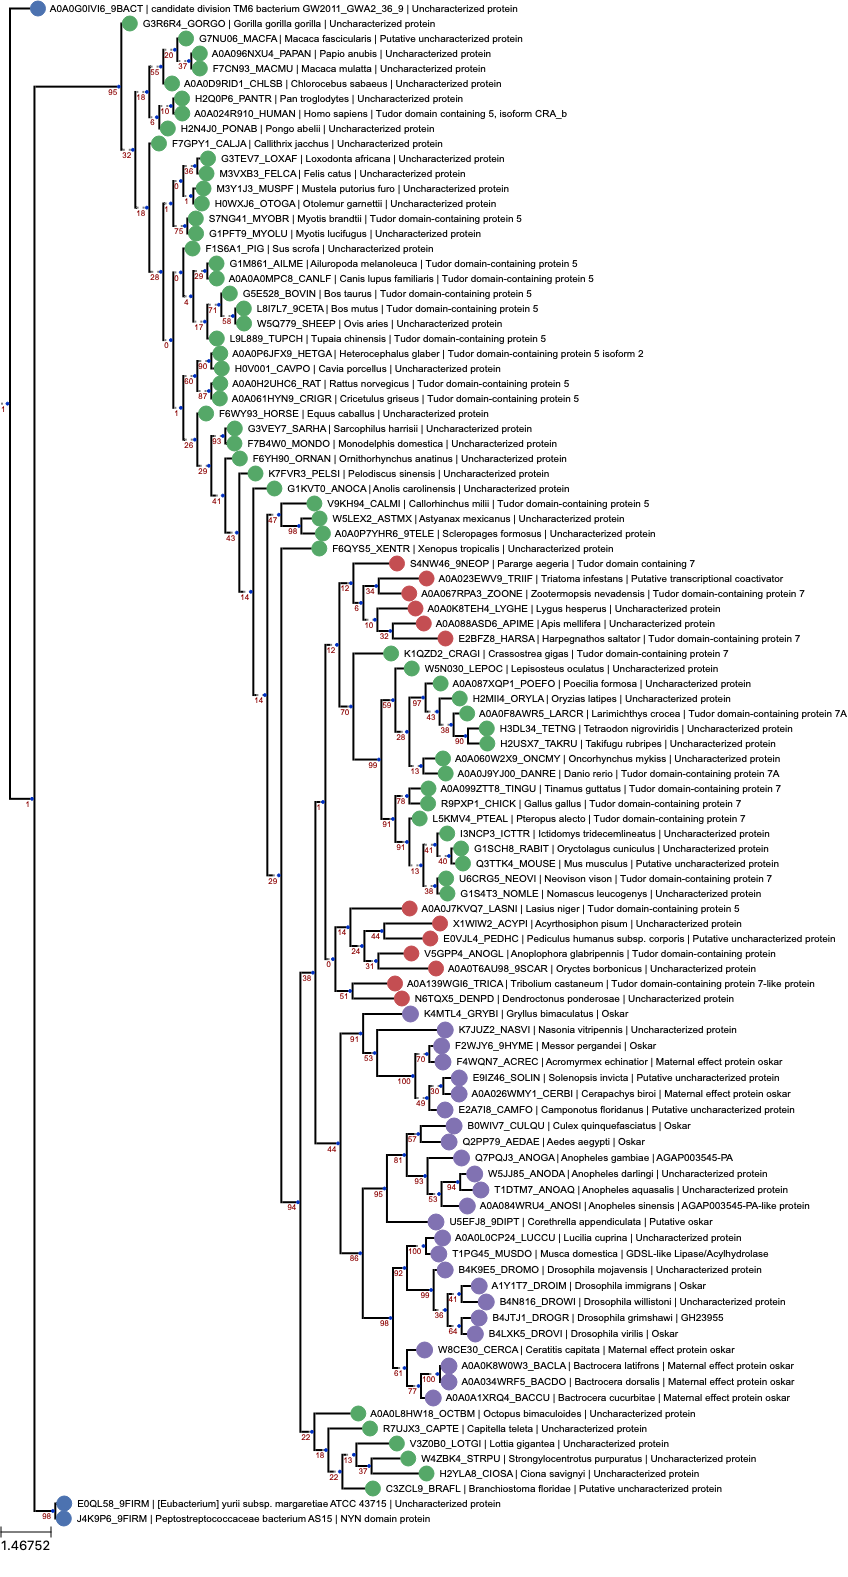

In [17]:
LOTUS_animala.render('%%inline', tree_style=ts)

In [18]:
LOTUS_animala.render('LOTUS_tcoffee.pdf', tree_style=ts, units='mm', h=247, dpi=600)
LOTUS_animala.render('LOTUS_tcoffee.png', tree_style=ts, units='mm', h=247, dpi=600)
LOTUS_animala.render('LOTUS_tcoffee.svg', tree_style=ts, units='mm', h=247, dpi=600)

{'nodes': [[20.349112966626507,
   1486.0843738609422,
   35.14846785144578,
   1500.8837287457616,
   0,
   None],
  [110.84071744638254,
   1.8499193606024098,
   170.03813698565963,
   61.04733889987952,
   1,
   None],
  [110.84071744638248,
   2948.1197960340533,
   125.64007233120176,
   2962.919150918872,
   2,
   None],
  [432.2578893635785,
   313.18296177003356,
   447.0572442483978,
   327.9823166548528,
   3,
   None],
  [450.7572090272389,
   57.34750017867471,
   509.954628566516,
   116.54491971795181,
   4,
   None],
  [484.055631460446,
   546.8193910341635,
   498.85498634526533,
   561.6187459189828,
   5,
   None],
  [535.8533735573135,
   332.75424498835844,
   550.6527284421328,
   347.55359987317775,
   6,
   None],
  [587.651115654181,
   239.10207735786148,
   602.4504705390002,
   253.90143224268076,
   7,
   None],
  [639.4488577510484,
   176.66729893753015,
   654.2482126358677,
   191.46665382234943,
   8,
   None],
  [658.786588509724,
   112.845080996747

# OSK Trees after tcoffee alignment

## RaxML tree

### Creating and decorating the tree

In [44]:
SGNH_RaxML_noPut = ete3.Tree(open(OSK_tcoffee_path).read())
decorate(SGNH_RaxML_noPut, bayes=False)
for leaf in SGNH_RaxML_noPut:
    if 'milii' in leaf.name:
        SGNH_RaxML_noPut.set_outgroup( leaf )
remove_duplicate_specie(SGNH_RaxML_noPut, ar=True)
trav = SGNH_RaxML_noPut.traverse()
for node in trav:
    node.img_style['hz_line_width'] = 2
    node.img_style['vt_line_width'] = 2
for leaf in SGNH_RaxML_noPut:
    if "candidate division" in leaf.specie:
        leaf.name = 'WWE3 bacterium'
    if leaf.kingdom == 'A':
        print(leaf)
        SGNH_RaxML_noPut.set_outgroup( leaf )
    leaf.name= '  '+ leaf.protid + ' | ' + leaf.specie + ' | ' + leaf.fullname

Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar

--Methanosarcina barkeri CM1

--Methanosarcina barkeri str. Wiesmoor


### Plotting the tree

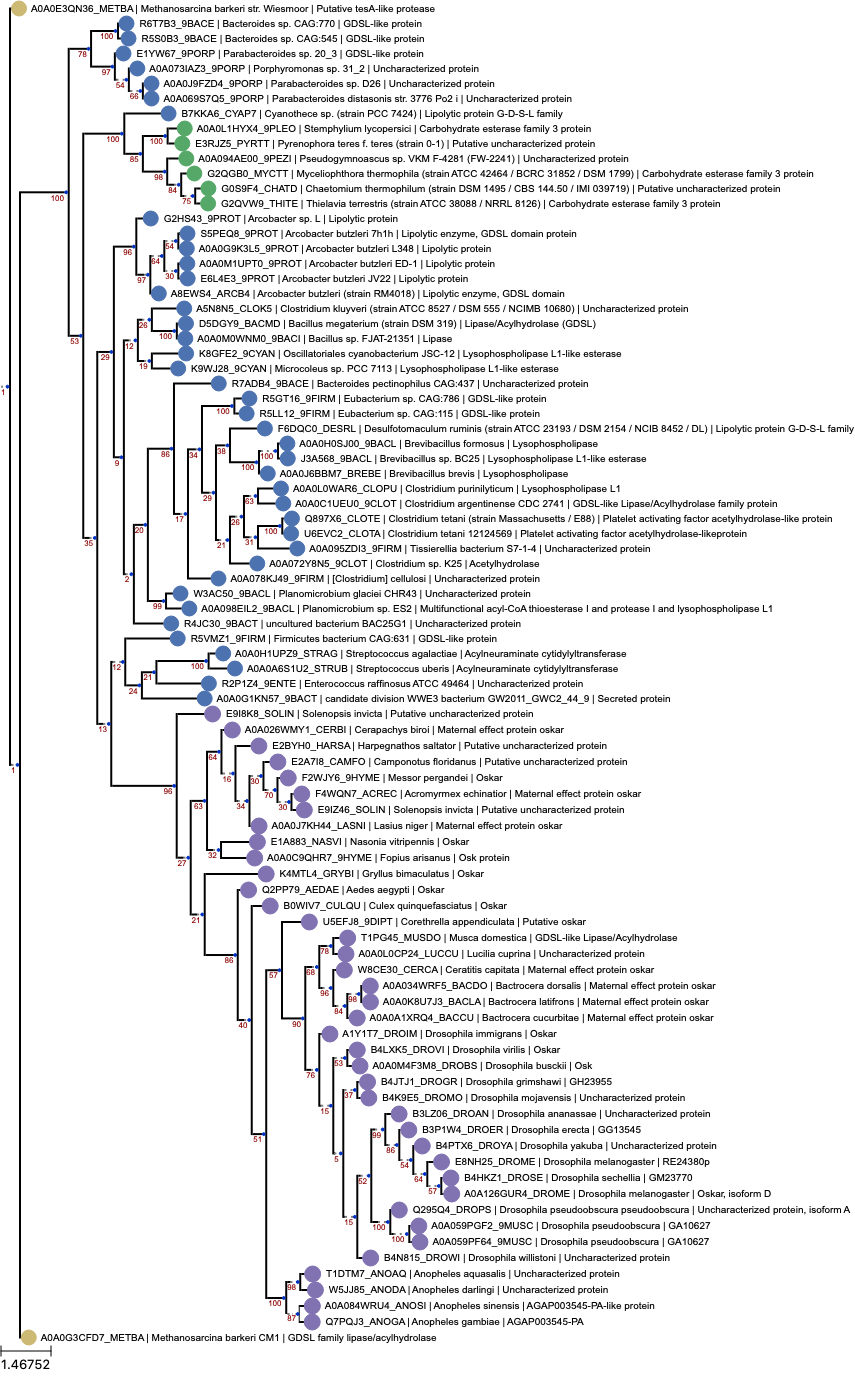

In [42]:
SGNH_RaxML_noPut.render('%%inline', tree_style=ts)

In [43]:
SGNH_RaxML_noPut.render('OSK_tcoffee.pdf', tree_style=ts, units='mm', h=247,  dpi=600)
SGNH_RaxML_noPut.render('OSK_tcoffee.png', tree_style=ts, units='mm', h=247,  dpi=600)
SGNH_RaxML_noPut.render('OSK_tcoffee.svg', tree_style=ts, units='mm', h=247,  dpi=600)

{'nodes': [[22.98750082261461,
   1607.8719424585604,
   39.7056832390616,
   1624.5901248750074,
   0,
   None],
  [46.142638510787584,
   2.089772802055874,
   113.01536817657555,
   68.96250246784385,
   1,
   None],
  [64.78295686373208,
   3188.576838490394,
   81.50113928017907,
   3205.2950209068413,
   2,
   None],
  [268.36178745312867,
   795.3705226895487,
   285.0799698695756,
   812.0887051059957,
   3,
   None],
  [361.8243961263173,
   195.65497859248123,
   378.54257854276426,
   212.3731610089282,
   4,
   None],
  [474.4461301339601,
   121.2068225192407,
   491.16431255040703,
   137.9250049356877,
   5,
   None],
  [495.3440005563042,
   64.7829568637321,
   562.2167302220921,
   131.65568652952007,
   6,
   None],
  [503.7592208218942,
   127.47614092540832,
   570.6319504876822,
   194.3488705911963,
   7,
   None],
  [461.2773090370612,
   270.1031346657217,
   477.9954914535082,
   286.8213170821687,
   8,
   None],
  [482.6809126365564,
   190.16932498708454,
 

# SOWHAT trees

In [25]:
ts = ete3.TreeStyle()
ts.show_branch_support = False
ts.show_scale = False
ts.show_leaf_name = True
ts.complete_branch_lines_when_necessary = True

In [26]:
LOTUS_SOWHAT_mono = ete3.Tree(open(LOTUS_sowhat).read())

In [28]:
decorate(LOTUS_SOWHAT_mono, bayes=False)
for leaf in LOTUS_SOWHAT_mono:
    if 'milii' in leaf.name:
        LOTUS_SOWHAT_mono.set_outgroup( leaf )
remove_duplicate_specie(LOTUS_SOWHAT_mono, ar=True)
trav = LOTUS_SOWHAT_mono.traverse()
for node in trav:
    node.img_style['hz_line_width'] = 2
    node.img_style['vt_line_width'] = 2
for leaf in LOTUS_SOWHAT_mono:
    if "candidate division" in leaf.specie:
        leaf.name = 'WWE3 bacterium'
    if leaf.kingdom == 'A':
        print(leaf)
        LOTUS_SOWHAT_mono.set_outgroup( leaf )
    leaf.name= '  '+ leaf.protid + ' | ' + leaf.specie + ' | ' + leaf.fullname

Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar


### Plotting the tree

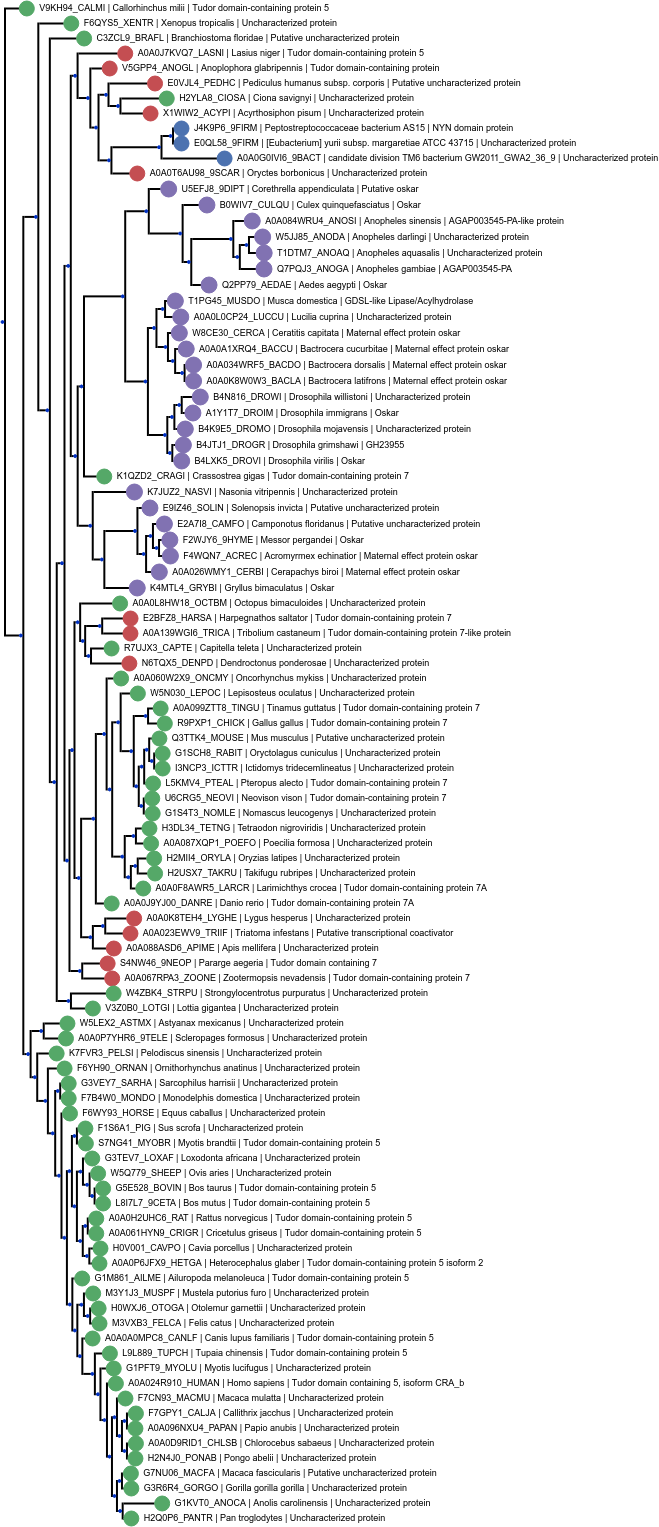

In [29]:
LOTUS_SOWHAT_mono.render('%%inline', tree_style=ts)

In [30]:
LOTUS_SOWHAT_mono.render('LOTUS_SOWHAT_BEST_TREE.pdf', tree_style=ts, units='mm', h=247,  dpi=600)
LOTUS_SOWHAT_mono.render('LOTUS_SOWHAT_BEST_TREE.png', tree_style=ts, units='mm', h=247,  dpi=600)
LOTUS_SOWHAT_mono.render('LOTUS_SOWHAT_BEST_TREE.svg', tree_style=ts, units='mm', h=247,  dpi=600)

{'faces': [[527.2081824024713,
   2401.4897180151866,
   1952.435970500585,
   2439.6995782859135,
   85,
   '  A0A139WGI6_TRICA | Tribolium castaneum | Tudor domain-containing protein 7-like protein'],
  [454.9339268670933,
   2458.804508421277,
   1383.4335314457574,
   2497.014368692004,
   87,
   '  R7UJX3_CAPTE | Capitella teleta | Uncharacterized protein'],
  [491.4118581655117,
   2573.4340892334576,
   1630.0656942331739,
   2611.6439495041845,
   92,
   '  A0A060W2X9_ONCMY | Oncorhynchus mykiss | Uncharacterized protein'],
  [528.8401392738527,
   5611.117980756248,
   1667.4939753415147,
   5649.327841026975,
   194,
   '  G7NU06_MACFA | Macaca fascicularis | Putative uncharacterized protein'],
  [522.9688126123959,
   2516.1192988273674,
   1638.6967325176217,
   2554.3291590980944,
   88,
   '  N6TQX5_DENPD | Dendroctonus ponderosae | Uncharacterized protein'],
  [396.50879208417865,
   4636.766543852711,
   1573.3724884225676,
   4674.976404123438,
   161,
   '  A0A0H2UHC6

### Schematics of constrain

In [207]:
Kindgom = "((Bacterias, Bacterias),(OSK, Eukaryotes), Archeas);"

In [208]:
t = ete3.Tree(Kindgom)

In [209]:
trav = t.traverse()
for node in trav:
    node.img_style['hz_line_width'] = 2
    node.img_style['vt_line_width'] = 2

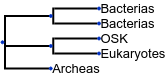

In [210]:
t.render('%%inline', tree_style=ts)

In [31]:
EukMono = "(Bacterias, Tudor 7, Tudor 5,(Oskar_LOTUS));"

In [32]:
t = ete3.Tree(EukMono)

In [33]:
trav = t.traverse()
for node in trav:
    node.img_style['hz_line_width'] = 2
    node.img_style['vt_line_width'] = 2

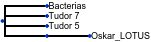

In [34]:
t.render('%%inline', tree_style=ts)

In [215]:
OSK = "(Archeas,(Bacterias, (Bacterias, OSK), (Bacterias, Eukaryotes)));"

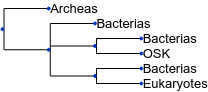

In [216]:
t = ete3.Tree(OSK)
t.render('%%inline', tree_style=ts)